## Healpy Info:


The standard coordinates are the colatitude $\theta$, 0 at the North Pole, $\pi / 2$ at the equator and $\pi$ at the South Pole and the longitude $\phi$ between 0 and $2 \pi$ eastward, in a Mollview projection, $\phi = 0$ is at the center and increases toward the left, then wraps around and comes from the right towards the center again.

## All-sky map for discrete simulation.

In [1]:
from shared.preface import *
import shared.functions as fct

# Generate (phi, theta) coord. pairs based on desired healpy map.
Nside = 2**1              # Specify nside parameter
Npix = 12 * Nside**2      # Number of pixels
pix_sr = (4*np.pi)/Npix   # Pixel size  [sr]
print(f'Healpy parameters: Nside={Nside}, Npix={Npix}, pix_sr={pix_sr}')
hp_thetas, hp_phis = np.array(hp.pixelfunc.pix2ang(Nside, np.arange(Npix)))

# Initialize parameters and files.
PRE = PRE(
    sim='L025N752', 
    z0_snap=36, z4_snap=13, DM_lim=10000,
    sim_dir=SIM_ROOT, sim_ver=SIM_TYPE,
    phis=hp_phis, thetas=hp_thetas, vels=10000,
    pre_CPUs=128, sim_CPUs=128, mem_lim_GB=224
)

# Halo parameters.
mass_gauge = 12.0
mass_range = 0.6
size = 1

hname = f'1e+{mass_gauge}_pm{mass_range}Msun'
fct.halo_batch_indices(
    PRE.Z0_STR, mass_gauge, mass_range, 'halos', size, 
    hname, PRE.SIM_DIR, PRE.OUT_DIR
)
halo_batch_IDs = np.load(f'{PRE.OUT_DIR}/halo_batch_{hname}_indices.npy')
halo_batch_params = np.load(f'{PRE.OUT_DIR}/halo_batch_{hname}_params.npy')
halo_num = len(halo_batch_params)

print('********Number density band********')
print('Halo batch params (Rvir,Mvir,cNFW):')
print(halo_batch_params)
print('***********************************')

Healpy parameters: Nside=2, Npix=48, pix_sr=0.2617993877991494
********************* Initialization *********************
# Initial conditions for neutrinos:
PHIs = 48, THETAs=48, Vs=10000
Total neutrinos: 23040000
# Simulation parameters:
Simulation box: L025N752
Snapshot from 0036 (z=0) to 0013 (z=4)
Pre/Sim CPUs 128/128
DM limit for cells: 10000
DM mass of sim box in log10 Msun: 6.1577
Smoothening length of sim box in kpc: 0.65
# File management:
Box files directory: 
 /projects/0/einf180/Tango_sims/L025N752/DMONLY/SigmaConstant00
Output directory: 
 /gpfs/home4/zimmer/neutrino_clustering_V2/L025N752/DMONLY/SigmaConstant00
**********************************************************
********Number density band********
Halo batch params (Rvir,Mvir,cNFW):
[[253.5523526   12.24058042   6.9286026 ]]
***********************************


1.071608640210914


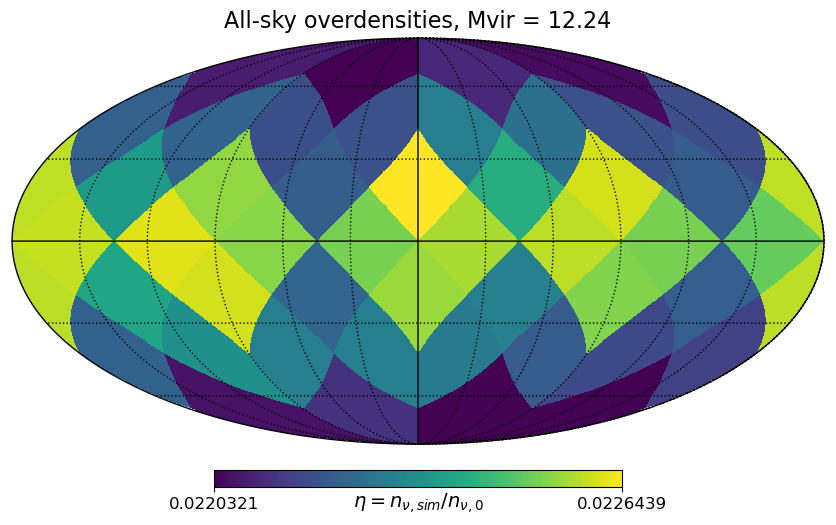

In [4]:
for halo_j, halo_ID in enumerate(halo_batch_IDs):

    # Load local number densities for all pixels.
    which_mass_eV = 0.01
    mass_choice_idx = (np.abs(NU_MRANGE-which_mass_eV)).argmin()
    etas_arr = np.zeros(Npix)
    for i in range(Npix):
        CPname = f'{PRE.NUS}nus_{hname}_halo{halo_j}_CoordPair{i+1}'
        out_file = f'{PRE.OUT_DIR}/number_densities_all_sky_{CPname}.npy'
        etas_arr[i] = np.load(f'{out_file}')[mass_choice_idx]/N0

    print(np.sum(etas_arr))

    hp.mollview(
        etas_arr, 
        title=f'All-sky overdensities, Mvir = {halo_batch_params[halo_j,1]:.2f}', 
        unit=r'$\eta = n_{\nu, sim} / n_{\nu, 0}$',
        # min=(0.5*np.min(etas_arr)), max=(1.5*np.max(etas_arr))
    )
    hp.graticule()
    plt.show()

## All-sky map for smooth simulation.

### Milky Way halo only.

Healpy parameters: Nside=4, Npix=192, pix_sr=0.06544984694978735
********************* Initialization *********************
# Initial conditions for neutrinos:
PHIs = 192, THETAs=192, Vs=10000
Total neutrinos: 368640000
# Simulation parameters:
Simulation box: LinfNinf
Sim CPUs 128
Output directory: 
 /gpfs/home4/zimmer/neutrino_clustering_V2/LinfNinf
Halos in smooth sim: MW
**********************************************************
4.299203920930351


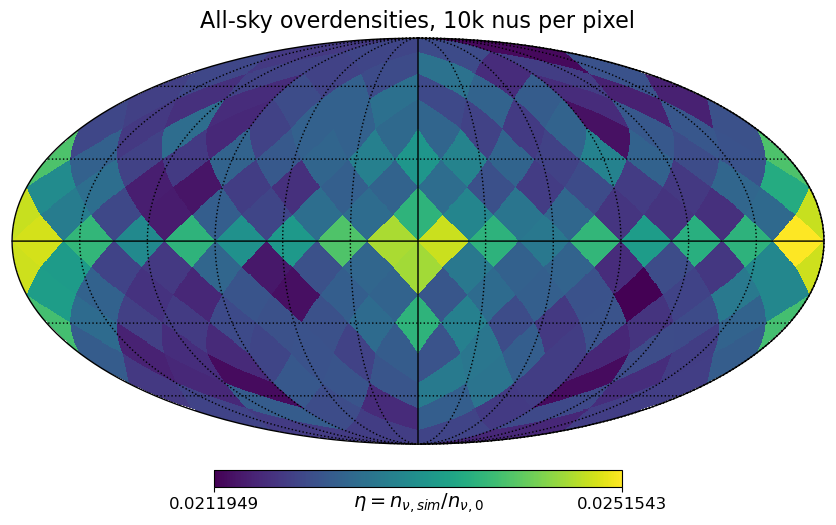

In [9]:
from shared.preface import *
import shared.functions as fct


# Generate (phi, theta) coord. pairs based on desired healpy map.
Nside = 2**2              # Specify nside parameter
Npix = 12 * Nside**2      # Number of pixels
pix_sr = (4*np.pi)/Npix   # Pixel size  [sr]
print(f'Healpy parameters: Nside={Nside}, Npix={Npix}, pix_sr={pix_sr}')
hp_thetas, hp_phis = np.array(hp.pixelfunc.pix2ang(Nside, np.arange(Npix)))


# Initialize parameters and files.
PRE_MW = PRE(
    sim='LinfNinf', phis=hp_phis, thetas=hp_thetas, vels=10000,
    sim_CPUs=128, MW_HALO=True
)

# Load local number densities for all pixels.
which_mass_eV = 0.3
mass_choice_idx = (np.abs(NU_MRANGE-which_mass_eV)).argmin()
etas_arr_MW = np.zeros(Npix)
for i in range(Npix):
    CPname = f'{PRE_MW.NUS}nus_smooth_{PRE_MW.HALOS}_{SOLVER}_CoordPair{i+1}'
    out_file = f'{PRE_MW.OUT_DIR}/number_densities_{CPname}.npy'
    etas_arr_MW[i] = np.load(f'{out_file}')[mass_choice_idx]/N0

print(np.sum(etas_arr_MW))

hp.mollview(etas_arr_MW, title='All-sky overdensities, 10k nus per pixel', unit=r'$\eta = n_{\nu, sim} / n_{\nu, 0}$')
hp.graticule()
plt.show()

### Milky Way + Virgo Cluster halos.

Healpy parameters: Nside=4, Npix=192, pix_sr=0.06544984694978735
********************* Initialization *********************
# Initial conditions for neutrinos:
PHIs = 192, THETAs=192, Vs=10000
Total neutrinos: 368640000
# Simulation parameters:
Simulation box: LinfNinf
Sim CPUs 128
Output directory: 
 /gpfs/home4/zimmer/neutrino_clustering_V2/LinfNinf
Halos in smooth sim: MW+VC
**********************************************************
4.66011649326202


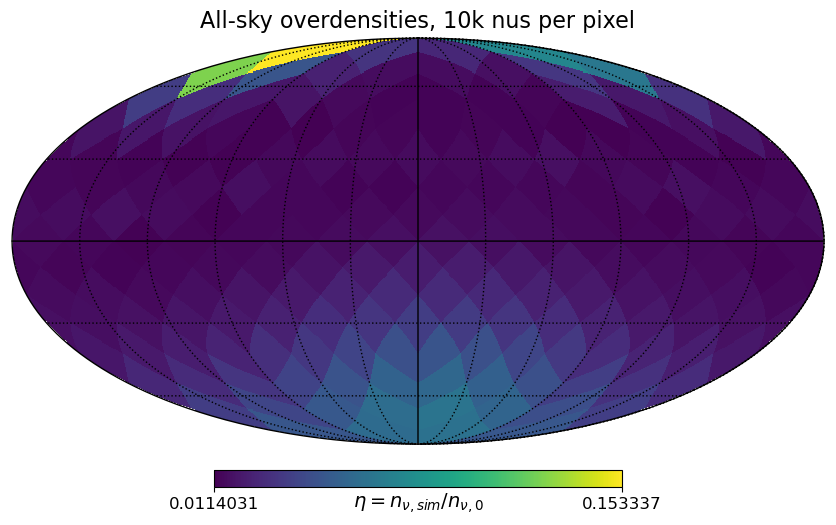

In [8]:
from shared.preface import *
import shared.functions as fct


# Generate (phi, theta) coord. pairs based on desired healpy map.
Nside = 2**2              # Specify nside parameter
Npix = 12 * Nside**2      # Number of pixels
pix_sr = (4*np.pi)/Npix   # Pixel size  [sr]
print(f'Healpy parameters: Nside={Nside}, Npix={Npix}, pix_sr={pix_sr}')
hp_thetas, hp_phis = np.array(hp.pixelfunc.pix2ang(Nside, np.arange(Npix)))


# Initialize parameters and files.
PRE_VC = PRE(
    sim='LinfNinf', phis=hp_phis, thetas=hp_thetas, vels=10000,
    sim_CPUs=128, MW_HALO=True, VC_HALO=True
)

# Load local number densities for all pixels.
which_mass_eV = 0.3
mass_choice_idx = (np.abs(NU_MRANGE-which_mass_eV)).argmin()
etas_arr_VC = np.zeros(Npix)
for i in range(Npix):
    CPname = f'{PRE_VC.NUS}nus_smooth_{PRE_VC.HALOS}_{SOLVER}_CoordPair{i+1}'
    out_file = f'{PRE_VC.OUT_DIR}/number_densities_{CPname}.npy'
    etas_arr_VC[i] = np.load(f'{out_file}')[mass_choice_idx]/N0

print(np.sum(etas_arr_VC))


# Check where Virgo Cluster is.
show_VC = False
if show_VC:
    VC_vec = hp.ang2vec(GLON_VC, GLAT_VC, lonlat=True)
    ipix_disc = hp.query_disc(nside=Nside, vec=VC_vec, radius=np.radians(10))
    etas_arr_VC[ipix_disc] = hp.UNSEEN

hp.mollview(etas_arr_VC, title='All-sky overdensities, 10k nus per pixel', unit=r'$\eta = n_{\nu, sim} / n_{\nu, 0}$')
hp.graticule()
plt.show()

### Number density plot, by summing pixels.

MW+VC


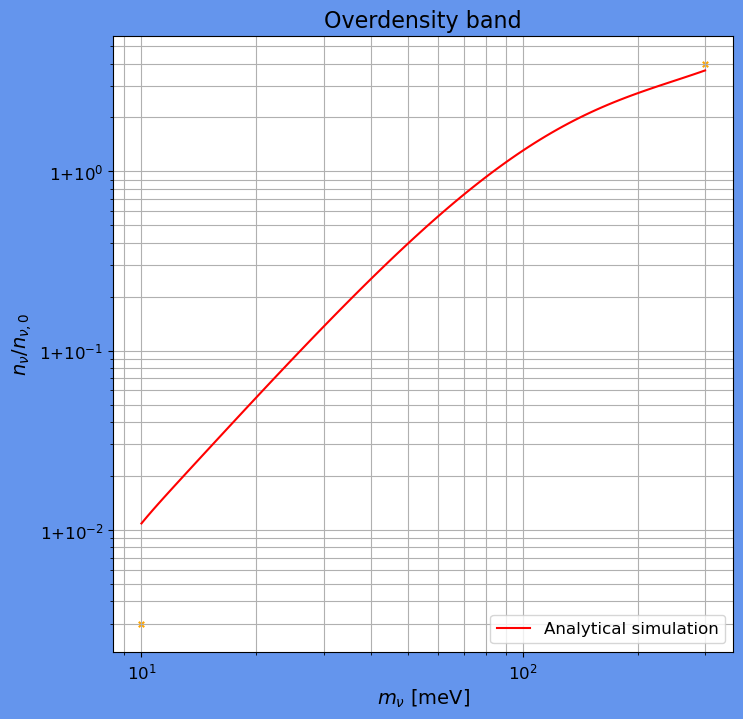

In [4]:
def plot_etas_from_all_sky(etas_smooth, 
    m_nu_range, fig_dir, fname, show=False, Mertsch=False
):

    fig, ax = plt.subplots(1,1)
    fig.patch.set_facecolor('cornflowerblue')

    # Plot smooth simulation.
    ax.plot(
        m_nu_range*1e3, (etas_smooth-1), color='red', ls='solid', 
        label='Analytical simulation'
    )

    if Mertsch:
        # Plot endpoint values from Mertsch et al.
        x_ends = [1e1, 3*1e2]
        y_ends = [3*1e-3, 4]
        ax.scatter(x_ends, y_ends, marker='x', s=15, color='orange')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'Overdensity band')
    ax.set_xlabel(r'$m_{\nu}$ [meV]')
    ax.set_ylabel(r'$n_{\nu} / n_{\nu, 0}$')
    # ax.set_ylim(1e-3, 1e1)
    plt.grid(True, which="both", ls="-")
    plt.legend(loc='lower right')

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(fct.y_fmt))

    fig_out = f'{fig_dir}/etas_{fname}.pdf'
    plt.savefig(
        fig_out, facecolor=fig.get_facecolor(), edgecolor='none', 
        bbox_inches='tight'
    )
    if show:
        plt.show()
    else:
        plt.close()


# PRE_FIG = PRE_MW
PRE_FIG = PRE_VC
print(PRE_FIG.HALOS)

fig_dir = f'{os.getcwd()}/figures'
fname = f'smooth_{PRE_FIG.HALOS}'

# Load local number densities for all pixels.
etas_arr_l = []
for i in range(Npix):
    CPname = f'{PRE_FIG.NUS}nus_smooth_{PRE_FIG.HALOS}_{SOLVER}_CoordPair{i+1}'
    out_file = f'{PRE_FIG.OUT_DIR}/number_densities_{CPname}.npy'
    etas_arr_l.append(np.load(f'{out_file}')/N0)

etas_all_masses = np.sum(np.array(etas_arr_l), axis=0)

plot_etas_from_all_sky(
    etas_all_masses, NU_MRANGE, fig_dir, fname, show=True, Mertsch=True
)

In [ ]:
fig_dir = f'{os.getcwd()}/figures'
splits = re.split('/', SIM_TYPE)
fname = f'{splits[0]}_{splits[1]}_{hname}'
fct.plot_eta_z_back_1Halo(u_all, NU_MASSES, fig_dir, fname, show=True)